### Setup

In [68]:
!pip install -Uqq diffusers transformers datasets accelerate ftfy bitsandbytes wandb

### Dataset

In [2]:
import torch
from torch import Tensor
import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from torch.utils.data import Dataset, DataLoader
from typing import List, Dict
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from transformers import CLIPFeatureExtractor, CLIPTextModel
from argparse import Namespace
import random
from tqdm.auto import tqdm
import math
import wandb

device = 'cuda' if torch.cuda.is_available() else 'cpu'
wandb.login()

wandb: Currently logged in as: matt24. Use `wandb login --relogin` to force relogin


True

In [3]:
from datasets import load_dataset

dataset_name = 'lewtun/corgi'
dataset = load_dataset(dataset_name, split='train')

dataset

Using custom data configuration lewtun--corgi-387a0d84d49c152d
Found cached dataset parquet (/root/.cache/huggingface/datasets/lewtun___parquet/lewtun--corgi-387a0d84d49c152d/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Dataset({
    features: ['image'],
    num_rows: 5
})

In [4]:
from PIL import Image

def image_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    
    return grid

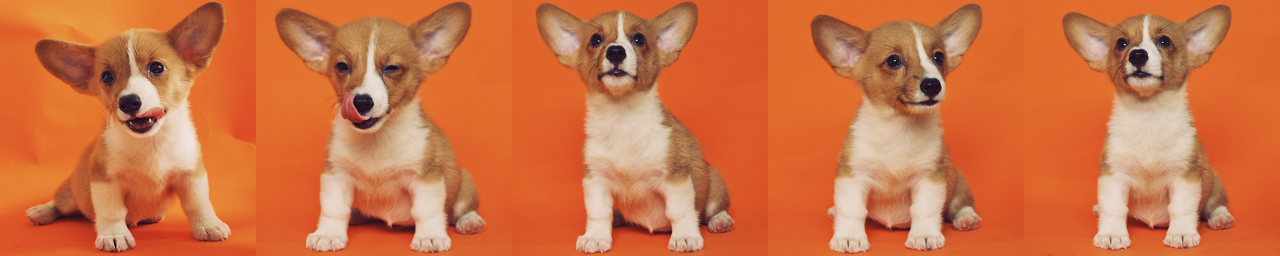

In [5]:
image_grid([image.resize((256, 256)) for image in dataset['image']], rows=1, cols=5)

In [6]:
unique_id = 'ccorgi'
class_type = 'dog'
instance_prompt = f'a photo of {unique_id} {class_type}'
print(instance_prompt)

a photo of ccorgi dog


In [7]:
from torch.utils.data import Dataset
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(self, dataset, instance_prompt, tokenizer, img_size=512):
        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self.tokenizer = tokenizer
        # self.img_size = img_size
        
        self.img_transforms = transforms.Compose([
            transforms.Resize(img_size),
            transforms.CenterCrop(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]['image']
        example['instance_image'] = self.img_transforms(image)
        example['instance_input_ids'] = self.tokenizer(self.instance_prompt,
                                                       padding='do_not_pad',
                                                       truncation=True,
                                                       max_length=self.tokenizer.model_max_length).input_ids
        
        return example

In [8]:
from transformers import CLIPTokenizer

sd_ckpt = 'CompVis/stable-diffusion-v1-4'
tokenizer = CLIPTokenizer.from_pretrained(sd_ckpt, subfolder='tokenizer')

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer, img_size=256)

### Dataloader

In [9]:
def collate_fn(examples: List[Dict[str, Tensor]]) -> Dict[str, List[Tensor]]:
    input_ids = [example['instance_input_ids'] for example in examples]
    pixel_values = [example['instance_image'] for example in examples]
    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()
    
    input_ids = tokenizer.pad({'input_ids': input_ids}, padding=True, return_tensors='pt').input_ids
    
    batch = {'input_ids': input_ids,
             'pixel_values': pixel_values}
    
    return batch

In [10]:
examples = [train_dataset[i] for i in range(len(train_dataset))]
batch = collate_fn(examples)
# batch

In [11]:
text_encoder = CLIPTextModel.from_pretrained(sd_ckpt, subfolder='text_encoder')
vae = AutoencoderKL.from_pretrained(sd_ckpt, subfolder='vae')
unet = UNet2DConditionModel.from_pretrained(sd_ckpt, subfolder='unet')
feature_extractor = CLIPFeatureExtractor.from_pretrained('openai/clip-vit-base-patch32')

In [12]:
batch_size = 1

train_dl = DataLoader(dataset=train_dataset,
                      batch_size=batch_size,
                      shuffle=True,
                      collate_fn=collate_fn)

In [13]:
batch = next(iter(train_dl))
# batch

### Fine-tuning with Accelerate

In [14]:
lr = 2e-6
max_train_steps = 400

args = Namespace(
    pretrained_model_name_or_path=sd_ckpt,
    resolution=512,
    instance_prompt=instance_prompt,
    train_dataset=train_dataset,
    train_batch_size=1,
    learning_rate=lr,
    max_train_steps=max_train_steps,
    gradient_accumulation_steps=1,
    max_grad_norm=1.,
    gradient_checkpointing=True,
    use_8bit_adam=True,
    sample_batch_size=2,
    output_dir='my-dreambooth',
    seed=42
)

In [15]:
def train_fn(text_encoder, vae, unet):
    
    # init Accelerator
    accelerator = Accelerator(gradient_accumulation_steps=args.gradient_accumulation_steps)
    
    # set seed
    set_seed(args.seed)
    
    # enable gradient checkpointing
    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        
    # optimizer
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW
    
    optimizer = optimizer_class(params=unet.parameters(), lr=args.learning_rate)
    
    # init noise scheduler
    noise_scheduler = DDPMScheduler(beta_start=8.5e-3,
                                    beta_end=1.2e-2,
                                    beta_schedule='scaled_linear',
                                    num_train_timesteps=1000)
    
    # define train dataloader
    train_dl = DataLoader(dataset=args.train_dataset,
                          batch_size=args.train_batch_size,
                          collate_fn=collate_fn,
                          shuffle=True)
    
    # prepare unet, optimizer and train dataloader to work with Accelerate
    unet, optimizer, train_dl = accelerator.prepare(unet, optimizer, train_dl)
    
    # move text encoder and VAE to GPUs
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)
    
    # calculate the total number of epochs based on the number of training steps adjusted to grad. acc. steps
    train_steps_per_epoch = math.ceil(len(train_dl) / args.gradient_accumulation_steps)
    train_epochs = math.ceil(args.max_train_steps / train_steps_per_epoch)
    
    # total batch size
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps
    
    # init progress bar
    progress_bar = tqdm(range(args.max_train_steps), disable=(not accelerator.is_local_main_process))
    progress_bar.set_description('Steps')
    global_step = 0
    
    # training loop
    for epoch in range(train_epochs):
        unet.train()
        for i, batch in enumerate(train_dl):
            with accelerator.accumulate(unet):
                # compute latents (i.e. image embeddings)
                with torch.inference_mode():
                    latents = vae.encode(batch['pixel_values']).latent_dist.sample()
                    latents *= 0.18215

                # init noise
                noise = torch.randn_like(latents).to(accelerator.device)

                # compute random timesteps
                batch_size = latents.shape[0]
                num_train_ts = noise_scheduler.num_train_timesteps
                timesteps = torch.tensor([random.randint(0, num_train_ts-1) for _ in range(batch_size)])
                timesteps = timesteps.to(accelerator.device)

                # add noise to latents
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # compute text embeddings
                with torch.inference_mode():
                    text_embeds = text_encoder(batch['input_ids'])[0]
                text_embeds = torch.clone(text_embeds)

                # predict noise (forward pass)
                noise_pred = unet(noisy_latents, timesteps, text_embeds).sample

                # compute loss
                loss = F.mse_loss(noise_pred, noise, reduction='none').mean([1, 2, 3]).mean()

                # backward pass
                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)

                # optimizer step & zero grad
                optimizer.step()
                optimizer.zero_grad()

            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {'loss': loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break
        accelerator.wait_for_everyone()
    
    if accelerator.is_main_process:
        print(f'Loading pipeline and saving it to {args.output_dir}')
        
        scheduler = PNDMScheduler(
            beta_start=8.5e-3,
            beta_end=1.2e-2,
            beta_schedule='scaled_linear',
            skip_prk_steps=True,
            steps_offset=1
        )
        
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            feature_extractor=feature_extractor,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained('CompVis/stable-diffusion-safety-checker')
        )
        
        pipeline.save_pretrained(args.output_dir)

In [ ]:
from accelerate import notebook_launcher
num_of_gpus = 1
notebook_launcher(train_fn, args=(text_encoder, vae, unet), num_processes=num_of_gpus)

### Inference

In [ ]:
pipeline = StableDiffusionPipeline.from_pretrained(args.output_dir, torch_dtype=torch.float16).to(device)

In [ ]:
prompt = f"a photo of {unique_id} {class_type} with a Santa hat in the snowny forest."
negative_prompt = 'high contrast, blurry, low resolution, warped'
guidance_scale = 7

all_images = []
num_cols = 8
generator = torch.Generator(device=device).manual_seed(42)

for _ in range(num_cols):
    images = pipeline(prompt,
                      negative_prompt=negative_prompt,
                      guidance_scale=guidance_scale,
                      generator=generator).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)

In [31]:
optimizer_t = torch.optim.AdamW(params=unet.parameters(),
                                lr=lr)

In [43]:
optimizer_t.state_dict()['param_groups'][0]['lr']

2e-06

### Check

In [34]:
learning_rate = 2e-06
max_train_steps = 400

In [35]:
from argparse import Namespace

args = Namespace(
    pretrained_model_name_or_path=sd_ckpt,
    resolution=512, # Reduce this if you want to save some memory
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    learning_rate=learning_rate,
    max_train_steps=max_train_steps,
    train_batch_size=1,
    gradient_accumulation_steps=1, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # set this to True to lower the memory usage.
    use_8bit_adam=True,  # use 8bit optimizer from bitsandbytes
    seed=3434554,
    sample_batch_size=2,
    output_dir="my-dreambooth", # where to save the pipeline
    project_name='dreambooth-demo'
)

In [36]:
import math

import torch.nn.functional as F
from accelerate import Accelerator
from accelerate.utils import set_seed
from accelerate.logging import get_logger
from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import random
import wandb
import os

logger = get_logger(__name__)

def training_function(text_encoder, vae, unet):

    accelerator = Accelerator(gradient_accumulation_steps=args.gradient_accumulation_steps,
                              log_with="wandb",
                              logging_dir=os.path.join(args.output_dir, 'logs'))

    set_seed(args.seed)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    optimizer = optimizer_class(params=unet.parameters(), lr=args.learning_rate)

    noise_scheduler = DDPMScheduler(
        beta_start=0.00085,
        beta_end=0.012,
        beta_schedule="scaled_linear",
        num_train_timesteps=1000,
    )

    train_dataloader = DataLoader(
        dataset=args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )

    unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)

    # Move text_encode and vae to gpu
    text_encoder.to(accelerator.device)
    vae.to(accelerator.device)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps
    
    # init tracker
    # if accelerator.is_main_process:
    if accelerator.is_main_process:
        accelerator.init_trackers(project_name=args.project_name, config=args)
        
    
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.inference_mode():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents).to(accelerator.device)
                batch_size = latents.shape[0]
                
                # Sample a random timestep for each image
                # timesteps = torch.randint(
                #     0,
                #     noise_scheduler.config.num_train_timesteps,
                #     (batch_size,),
                #     device=latents.device,
                # ).long()
                max_train_ts = noise_scheduler.config.num_train_timesteps
                timesteps = (torch.tensor([random.randint(0, max_train_ts-1) for _ in range(batch_size)])
                             .to(latents.device))

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.inference_mode():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]
                encoder_hidden_states = torch.clone(encoder_hidden_states)

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                                         
                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                                         
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item(),
                    'lr': optimizer.state_dict()['param_groups'][0]['lr'],
                    'step': global_step,
                    'epoch': epoch}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        print(f"Loading pipeline and saving to {args.output_dir}...")
                                         
        scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
                                         
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=feature_extractor,
        )

        pipeline.save_pretrained(args.output_dir)
    
    
    accelerator.end_training()

In [37]:
from accelerate import notebook_launcher

num_of_gpus = 1  # CHANGE THIS TO MATCH THE NUMBER OF GPUS YOU HAVE
notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes=num_of_gpus)

Launching training on one GPU.


  0%|          | 0/400 [00:00<?, ?it/s]

Loading pipeline and saving to my-dreambooth...


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▂▁▁▁▁█▁▂▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,79
loss,0.01164
lr,0.0
step,400


In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16
).to(device)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache

In [ ]:
# Pick a funny prompt here and it will be used as the widget's default 
# when we push to the Hub in the next section
prompt = f"a photo of {unique_id} {class_type} with a Santa hat in the snow"

# Tune the guidance to control how closely the generations follow the prompt.
# Values between 7-11 usually work best
guidance_scale = 8
generator = torch.Generator(device=device).manual_seed(42)

num_cols = 4
all_images = []
for _ in range(num_cols):
    images = pipe(prompt,
                  guidance_scale=guidance_scale,
                  generator=generator).images
    all_images.extend(images)

image_grid(all_images, 1, num_cols)